In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.time import Time
import numpy as np
from astropy import units as u

np.set_printoptions(threshold=1000)

In [2]:
def getSunPos():
    lat = 46.8768628
    lon = 7.6212138
    start = Time("2022-10-25") + 7 * u.hour
    
    duration = 3 * 3600
    
    samples = 360

    dTimeArr = np.arange(0, duration, 3600 / samples) * u.hour / 3600
    timeArr = start + dTimeArr

    loc = EarthLocation(lon=lon*u.deg, lat=lat*u.deg)
    altaz = AltAz(obstime=timeArr, location=loc)
    
    sunPos = get_sun(timeArr).transform_to(altaz)

    return dTimeArr, sunPos.az.degree, sunPos.alt.degree

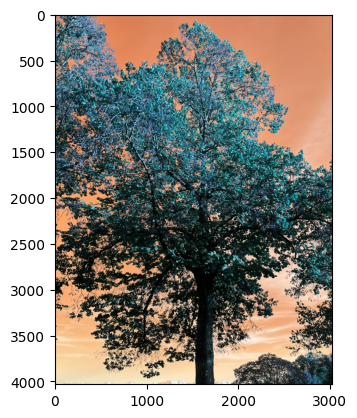

In [3]:
#filename = input("Filename: ")
filename = "IMG_0671.JPG"
tree_img = cv2.imread('C:/Users/patri/OneDrive/Bilder/Tree/' + filename)
plt.imshow(tree_img)

In [4]:
distance = 5
pos_az = 10

img_az = 135
img_alt = 43

sun_pos = getSunPos()

sun_az = sun_pos[1]
sun_alt = sun_pos[2]
sun_radius_deg = 0.533

res_x = tree_img.shape[1]
res_y = tree_img.shape[0]
pix_deg = res_x / 65

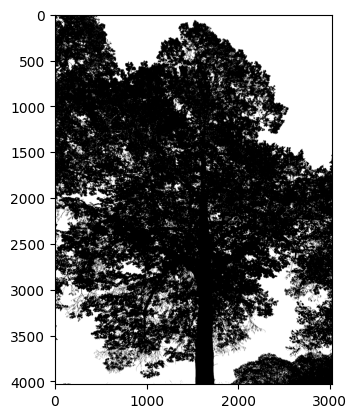

In [5]:
lower_bound = np.array([200, 0, 0])
upper_bound = np.array([360, 255, 255])

mask = cv2.inRange(tree_img, lower_bound, upper_bound)

plt.imshow(mask, cmap='gray')

In [6]:
cv2.imwrite("C:/Users/patri/OneDrive/Bilder/Tree/test_tree_gray.jpg", mask)

True

In [7]:
sun_az_rel = sun_az - img_az
sun_alt_rel = sun_alt - img_alt

center_x = sun_az_rel * pix_deg
center_y = sun_alt_rel * pix_deg

pos_x = (res_x / 2 + center_x).astype(int)
pos_y = (res_y / 2 - center_y).astype(int)
shape = (1,2)
coords = np.stack((pos_x, pos_y), axis=-1)

sun_radius = int(sun_radius_deg * pix_deg) // 2

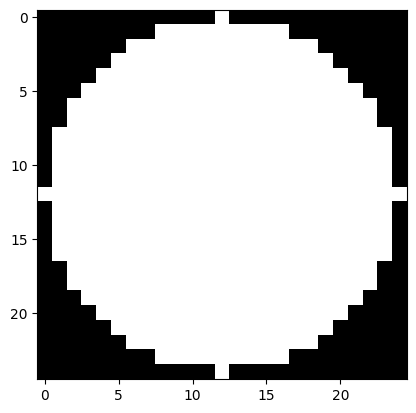

In [8]:
circle_mask = cv2.circle(np.zeros((sun_radius*2+1,sun_radius*2+1), dtype=int), (sun_radius,sun_radius), sun_radius, 255, -1)
plt.imshow(circle_mask, cmap='gray')

In [9]:
cropped_tree = np.array([mask[0:sun_radius*2+1, 0:sun_radius*2+1]])
for coord in coords:
    x = coord[0]
    y = coord[1]
    cropped_tree = np.append(cropped_tree, [mask[y-sun_radius:y+sun_radius+1, x-sun_radius:x+sun_radius+1]], axis=0)
cropped_tree = np.delete(cropped_tree, 0, axis=0)

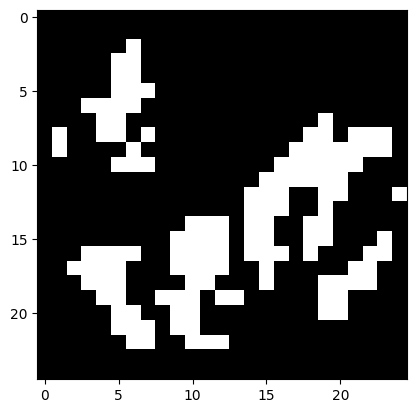

In [10]:
masked_tree = cropped_tree * circle_mask // 65025
plt.imshow(masked_tree[1], cmap='gray')

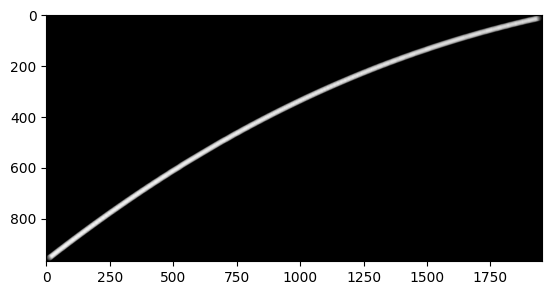

In [11]:
min_x = np.min(pos_x) - sun_radius
min_y = np.min(pos_y) - sun_radius
max_x = np.max(pos_x) + sun_radius + 1
max_y = np.max(pos_y) + sun_radius + 1

rel_x = pos_x - min_x
rel_y = pos_y - min_y

size_x = max_x - min_x
size_y = max_y - min_y

visualization = np.zeros((size_y, size_x), dtype=int)

for i, notimportant in enumerate(pos_x):
    visualization[rel_y[i]-sun_radius:rel_y[i]+sun_radius+1,rel_x[i]-sun_radius:rel_x[i]+sun_radius+1] = np.add(visualization[rel_y[i]-sun_radius:rel_y[i]+sun_radius+1,rel_x[i]-sun_radius:rel_x[i]+sun_radius+1], circle_mask)

plt.imshow(visualization, cmap='gray')

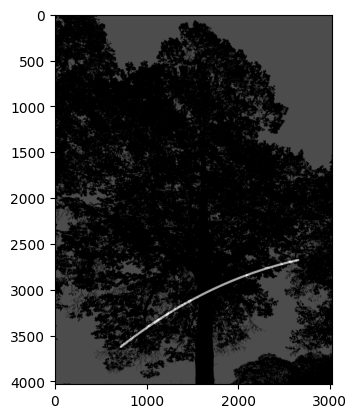

In [12]:
alpha = 0.3
beta = 1 - alpha

overlay = np.zeros_like(mask)
overlay[min_y:max_y,min_x:max_x] = visualization

whole_visualization = cv2.addWeighted(mask, alpha, overlay, beta, 0.0)

plt.imshow(whole_visualization, cmap='gray')

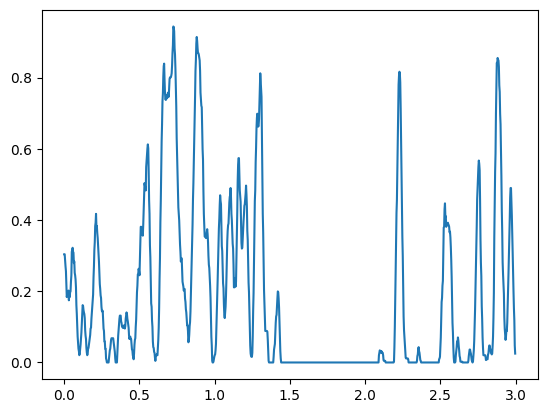

In [13]:
lai = (np.apply_over_axes(np.sum, masked_tree, [1,2]) / (np.sum(circle_mask) // 255)).reshape(-1)
plt.plot(sun_pos[0], lai)